# Data
- Select dataset and output some metadata

In [2]:
from domain.env import SWS, FEATURE_ENCODING, DATA_SLICE_AMOUNT, X_type, Y

print(f"use '{SWS}' dataset with {FEATURE_ENCODING} encoding, {DATA_SLICE_AMOUNT} samples and performance metric: {Y}")

use 'LLVM_energy' dataset with binary encoding, 100 samples and performance metric: energy


In [3]:
from application.init_pipeline import init_pipeline
from application.fully_bayesian_gp import get_data

ds, feature_names, X_train, X_test, y_train, y_test = init_pipeline(use_dummy_data=False)
data = get_data()
X_train, X_test, y_train, y_test, feature_names = data
measurement_df = ds.get_measurement_df() # is a incidence matrix

Checking if LLVM_energy isn't already extracted
   root  ee_instrument  simplifycfg  ipsccp  called_value_propagation  \
0     1              0            0       0                         0   
1     1              0            0       0                         0   
2     1              0            0       0                         0   
3     1              0            0       0                         0   
4     1              0            0       0                         0   

   basicaa  instcombine  inline  mergereturn  jump_threading  ...  licm  sink  \
0        0            0       0            0               0  ...     0     0   
1        0            0       0            0               0  ...     0     0   
2        0            0       0            0               0  ...     0     0   
3        0            0       0            0               0  ...     0     0   
4        0            0       0            0               0  ...     0     1   

   gvn  sccp  adce  perfor

In [16]:
from sklearn.preprocessing import OrdinalEncoder
print(X_train)
X = OrdinalEncoder().fit(X_train).transform(X_train)


[[0 0 1 ... 0 0 0]
 [0 1 1 ... 0 0 1]
 [0 0 0 ... 0 1 1]
 ...
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 1 0 1]
 [0 1 0 ... 1 0 0]]


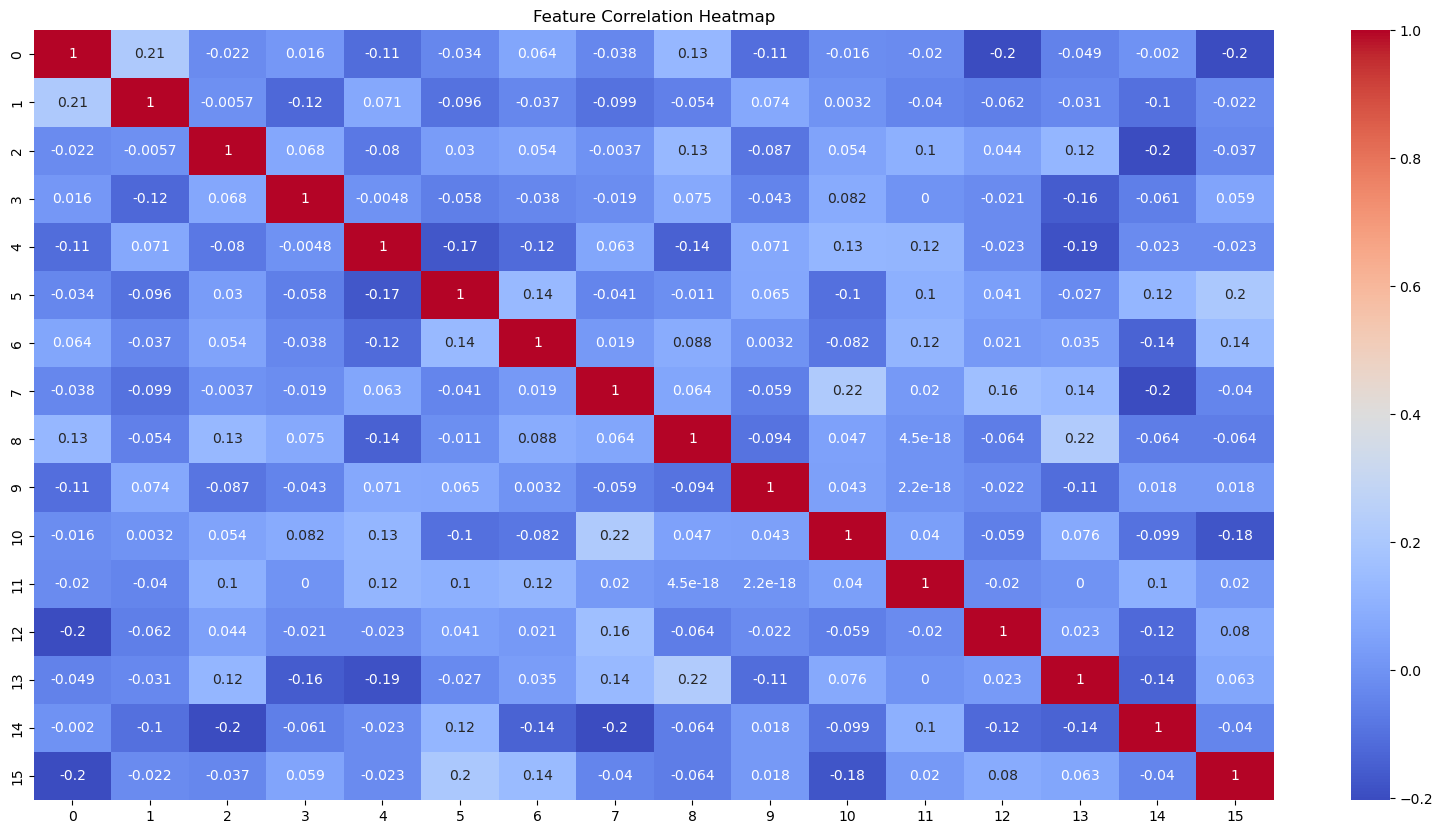

In [95]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

#corr_matrix = measurement_df.corr(method=pointbiserialr)
corr_matrix = np.corrcoef(X_train.T)
#corr_matrix = measurement_df.corr()

# Heatmap
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Pair Plot
#sns.pairplot(measurement_df, hue="sink")
#plt.show()

In [6]:
mean_corr = measurement_df.corr().drop(columns=["y"], index=["y"]).abs().mean().mean()
mean_corr
target_corr = measurement_df.corr()["y"].abs()
selected_features = target_corr[target_corr > mean_corr].index.tolist()
selected_features.remove("y")
print("Selected Features:", selected_features)

Selected Features: ['adce', 'called_value_propagation', 'inline', 'instcombine', 'ipsccp', 'jump_threading', 'licm', 'pgo_memop_opt', 'sink', 'tailcallelim']


called_value_propagation    469.003797
ipsccp                      215.302398
pgo_memop_opt               199.729096
inline                      184.381389
adce                        119.111952
tailcallelim                 93.515106
sink                         70.534461
licm                         64.091468
jump_threading               60.623332
instcombine                  58.039151
gvn                          36.017485
basicaa                      23.526679
mergereturn                  21.759386
ee_instrument                20.217456
sccp                         17.703297
simplifycfg                   9.882142
dtype: float64


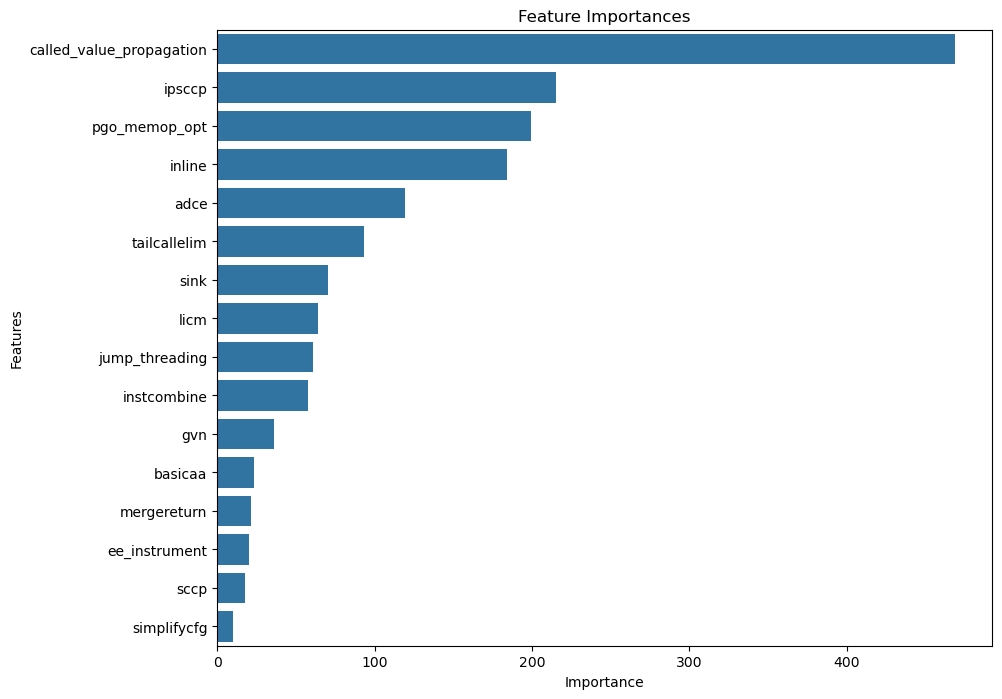

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoCV

# Fit the model
model = LassoCV(alphas=np.logspace(-2, 4, 1000))
model.fit(X_train, y_train)  # X is your features, y is your target variable

# Feature importances are the absolute values of the coefficients
feature_importances = pd.Series(abs(model.coef_), index=feature_names)

# Assuming 'feature_importances' is a dictionary or a Pandas Series 
# with feature names as keys and their importance (e.g., correlation coefficient) as values
# Example: feature_importances = {'feature1': 0.8, 'feature2': 0.75, ...}

# Convert to Pandas Series for easy plotting if it's not already
#feature_importances = measurement_df.corr()["y"].abs().sort_values(ascending=False)
feature_importances = pd.Series(feature_importances)

# Sort features based on importance
sorted_features = feature_importances.sort_values(ascending=False)
print(sorted_features)

# Create a bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_features.values, y=sorted_features.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


Applying a L2 norm (euclidian) to the features, we see a nearly logarithmic distribution -> Zipf's Law
which is good for convex optimization

## model metrics
- MSE
- MAPE
- WAIC

## "biconvex Kernel sorting"

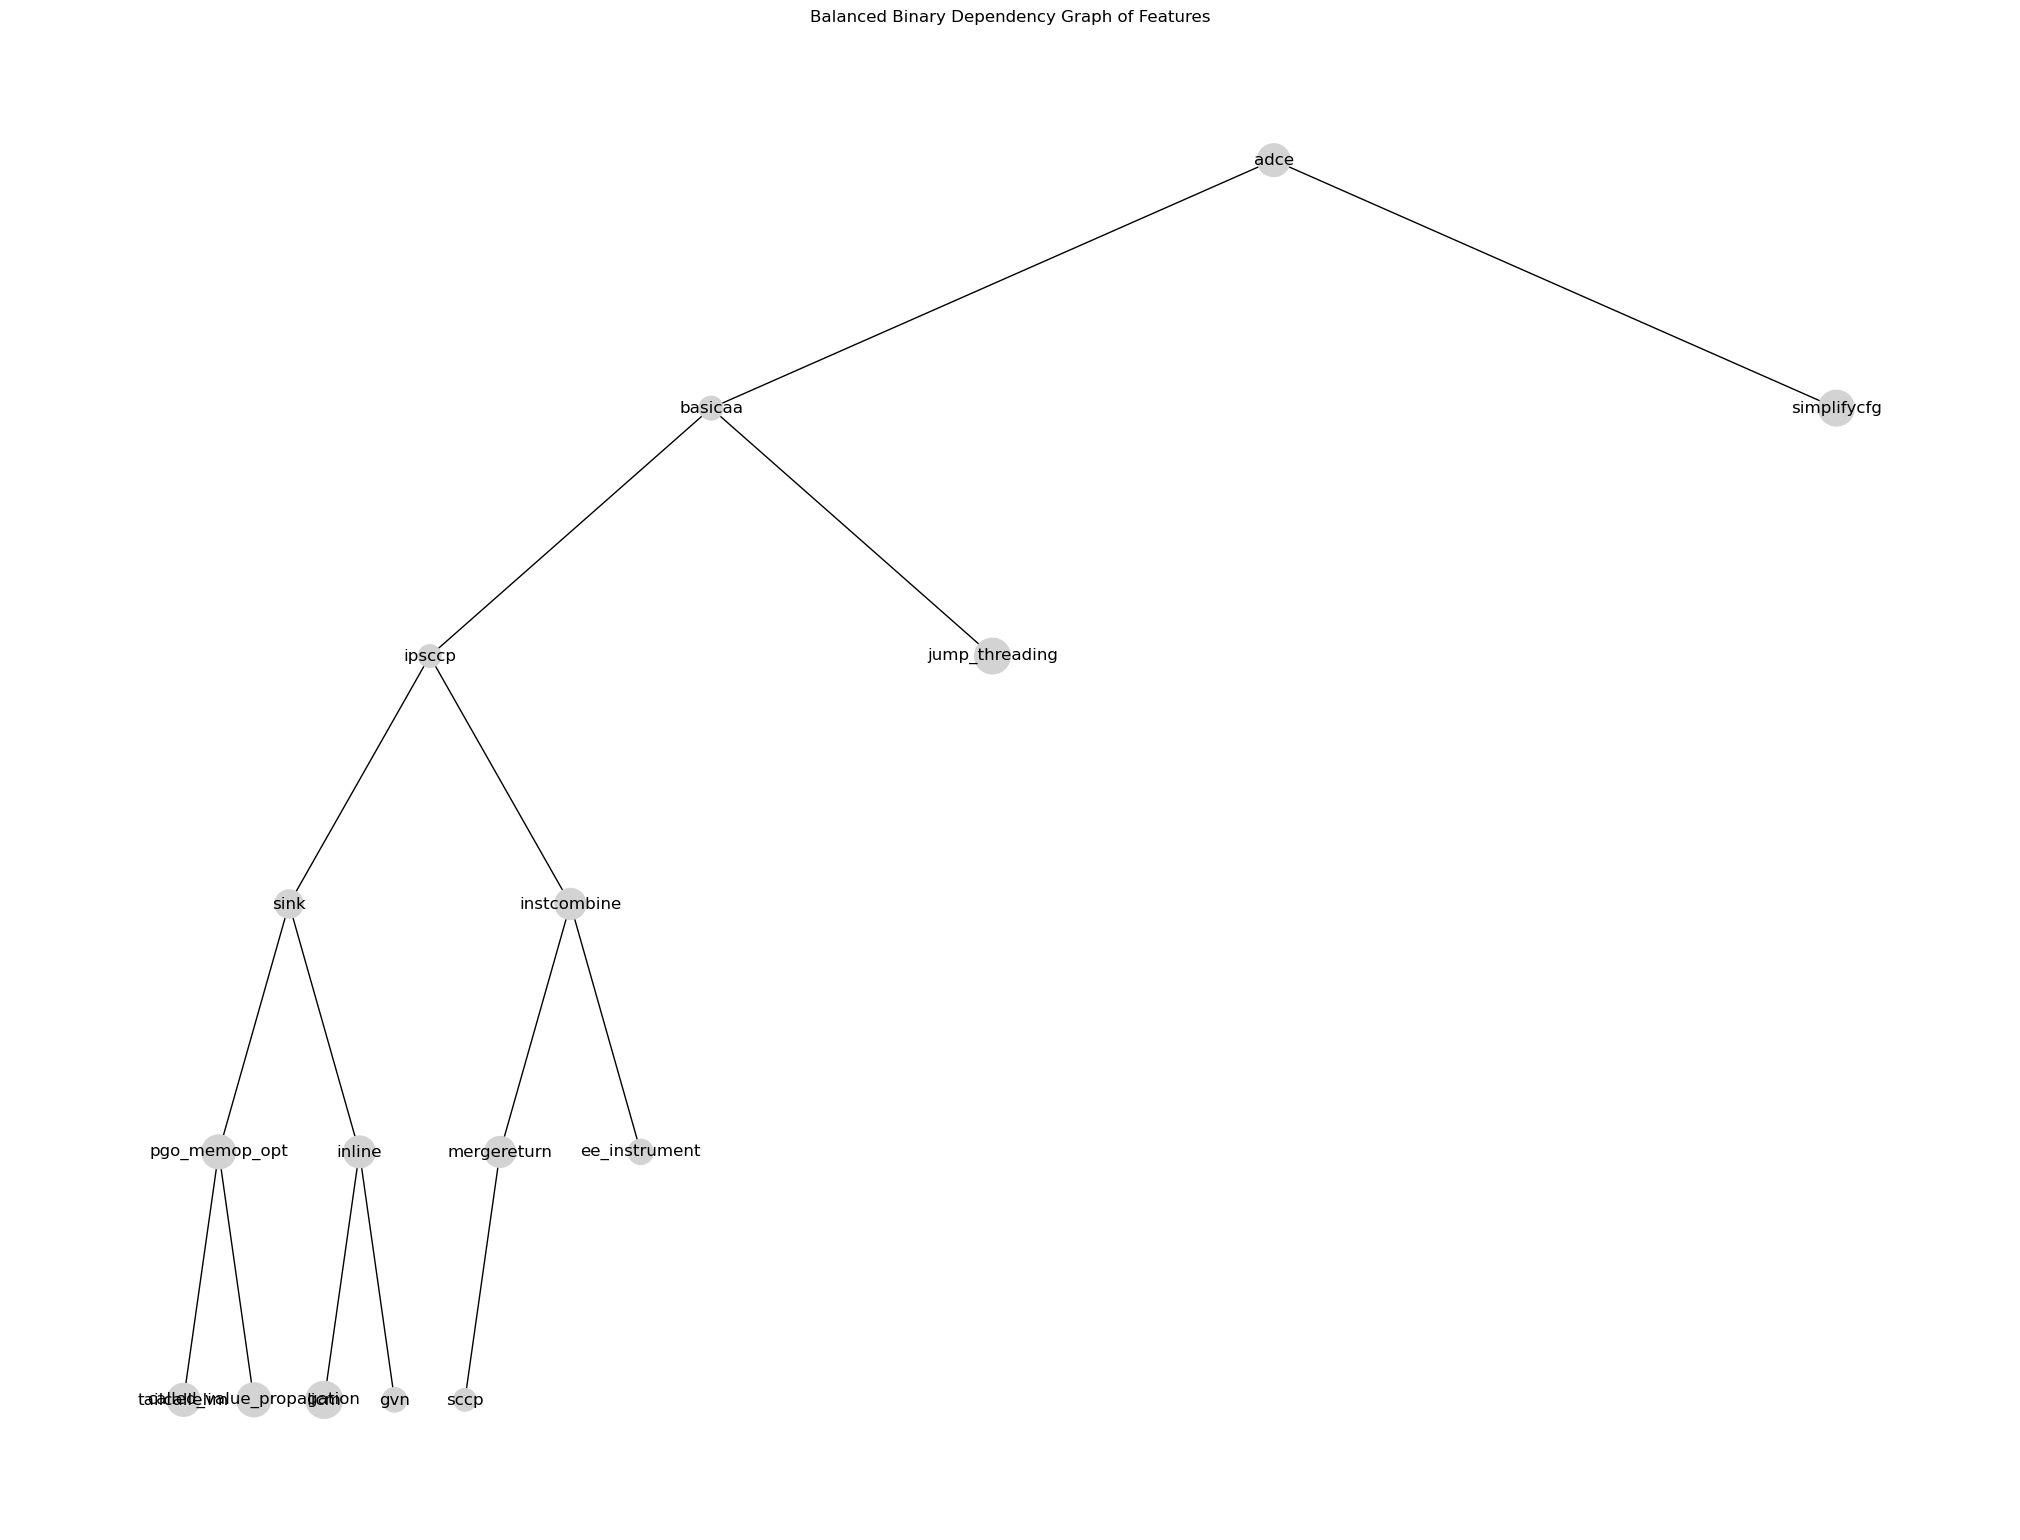

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import numpy as np
import random

def add_nodes(tree, current_node, max_depth, feature_names, current_depth=1):
    if current_depth > max_depth or len(feature_names) == 0:
        return

    # Randomly select features for left and right child nodes
    left_feature = feature_names.pop(random.randint(0, len(feature_names) - 1)) if feature_names else None
    right_feature = feature_names.pop(random.randint(0, len(feature_names) - 1)) if feature_names else None

    left_child = current_node * 2
    right_child = current_node * 2 + 1

    if left_feature:
        tree.add_node(left_child, label=left_feature, size=feature_importances.get(left_feature, 1))
        tree.add_edge(current_node, left_child)
    if right_feature:
        tree.add_node(right_child, label=right_feature, size=feature_importances.get(right_feature, 1))
        tree.add_edge(current_node, right_child)

    add_nodes(tree, left_child, max_depth, feature_names, current_depth + 1)
    add_nodes(tree, right_child, max_depth, feature_names, current_depth + 1)


def get_tree_layout(tree, root, width=4.0, vert_gap = 0.8, vert_loc = 0, xcenter = 0.5):
    """
    Creates a layout for nodes in a binary tree.
    """
    if not nx.is_tree(tree):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    def _hierarchy_pos(G, root, width=4.0, vert_gap = 0.8, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children) != 0:
            dx = width / 2 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G, child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                    parent = root)
        return pos

    return _hierarchy_pos(tree, root, width, vert_gap, vert_loc, xcenter)

# Example feature names and synthetic importance values
#feature_names = measurement_df.columns.tolist()
feature_names = list(feature_names)
feature_importances = {feature: np.random.uniform(0.5, 1.5) for feature in feature_names}  # Replace with actual importances

# Shuffle feature names to randomly assign them to tree nodes
random.shuffle(list(feature_names))

# Create a balanced binary tree
tree = nx.DiGraph()
root_feature = feature_names.pop(0)
tree.add_node(1, label=root_feature, size=feature_importances.get(root_feature, 1))

# Calculate the depth of the tree
depth = math.ceil(math.log2(len(measurement_df.columns) + 1))
add_nodes(tree, 1, depth, feature_names)

# Get tree layout
pos = get_tree_layout(tree, 1)
sizes = [tree.nodes[node]['size']*500 for node in tree.nodes()]
colors = ['skyblue' if node in feature_list else 'lightgray' for node in tree.nodes()]

# Draw the tree
plt.figure(figsize=(20, 15))
nx.draw(tree, pos, with_labels=True, labels=nx.get_node_attributes(tree, 'label'), node_color=colors, node_size=sizes, font_size=12, arrows=False)
plt.title('Balanced Binary Dependency Graph of Features')
plt.show()


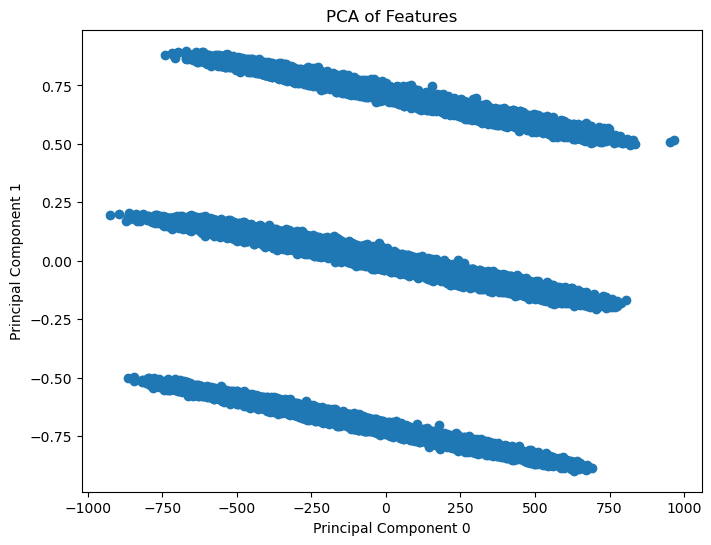

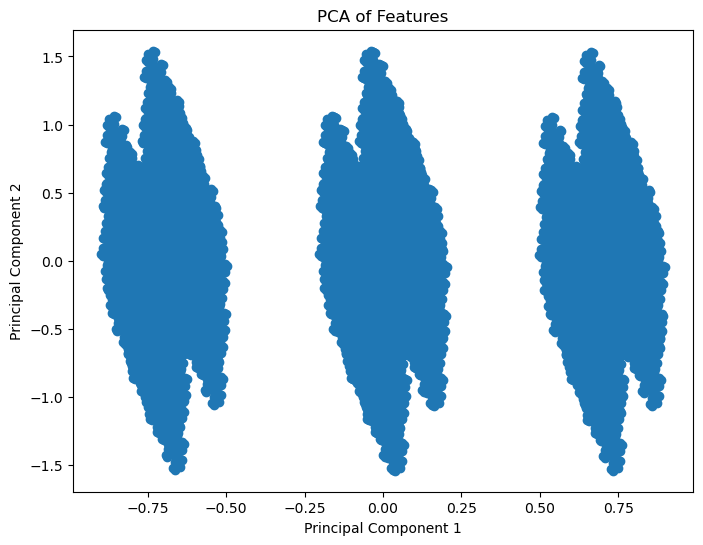

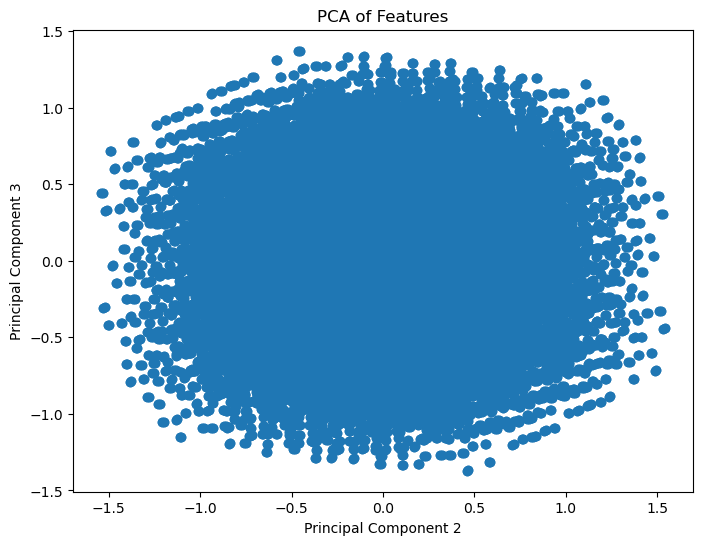

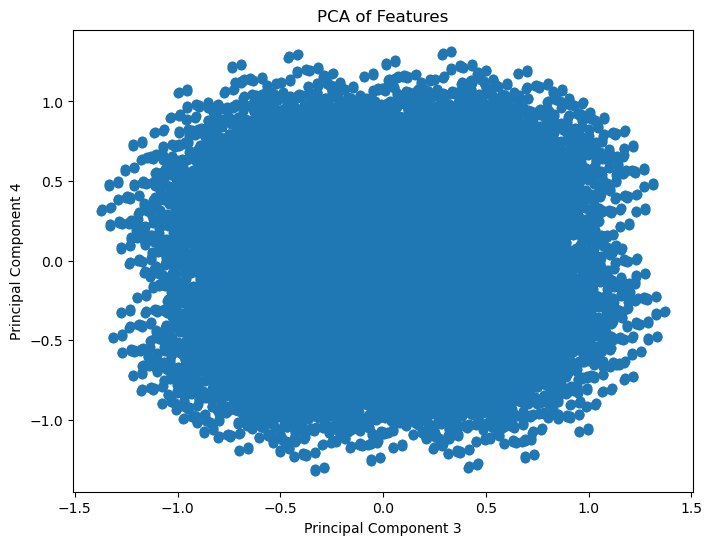

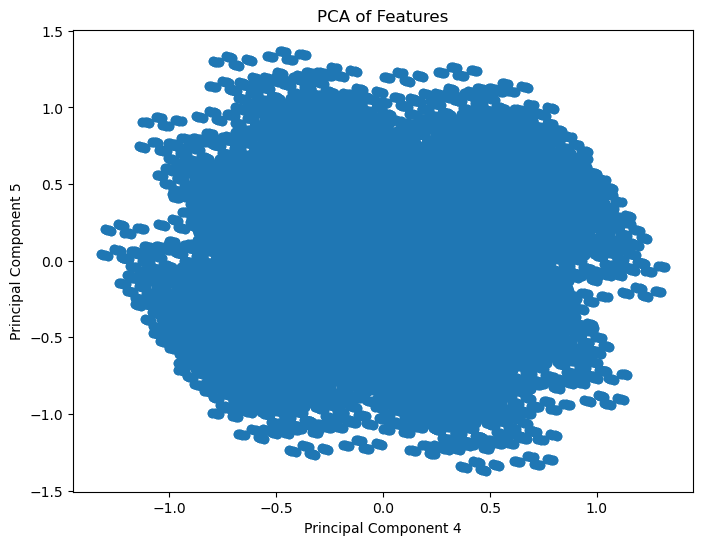

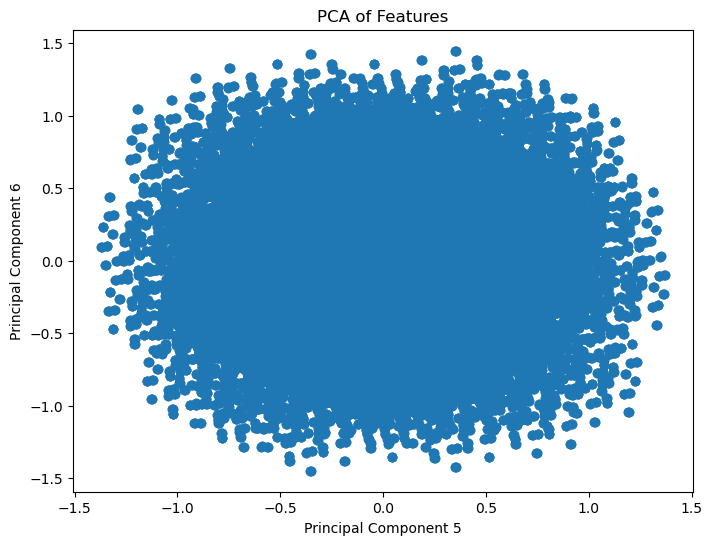

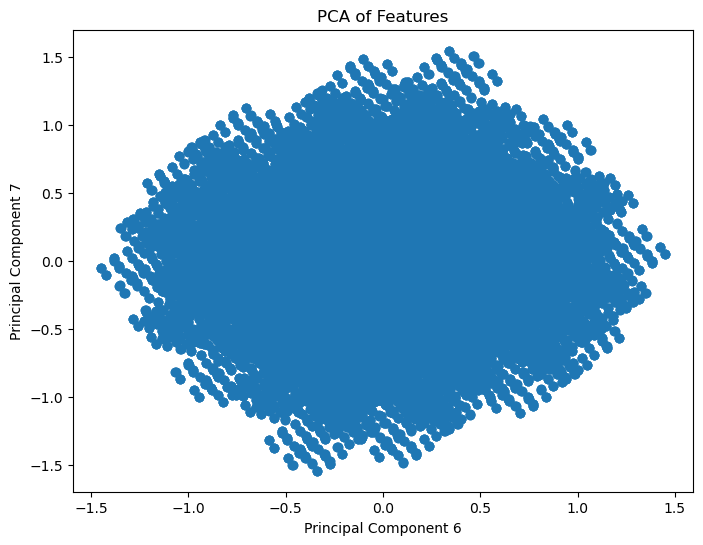

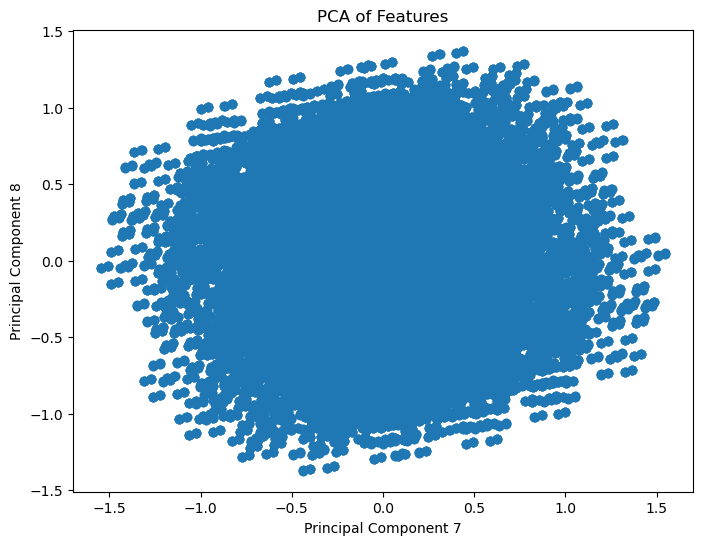

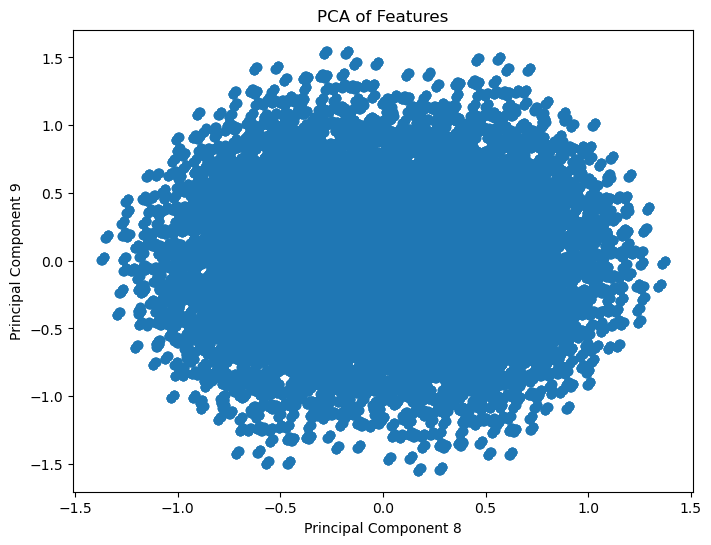

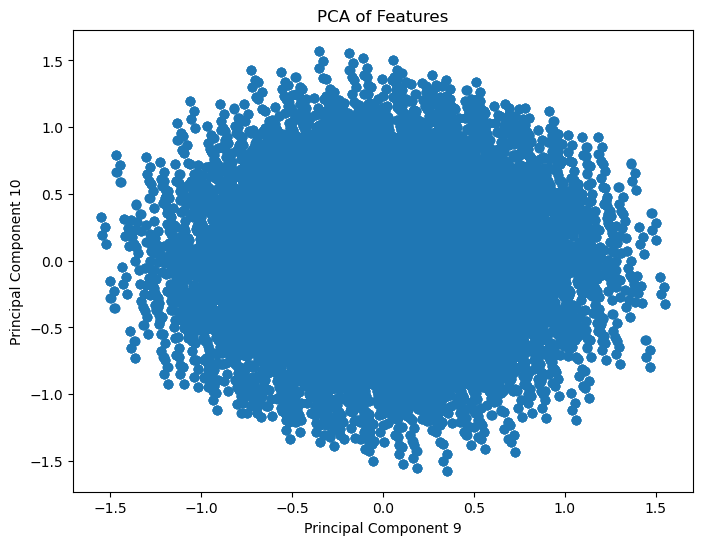

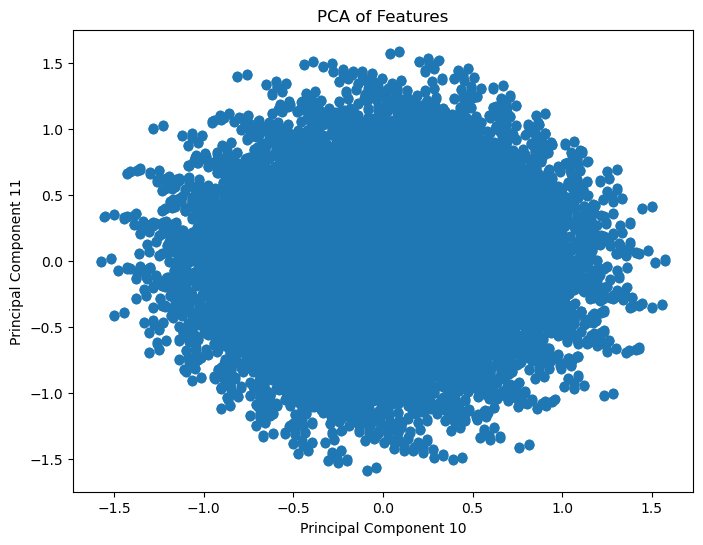

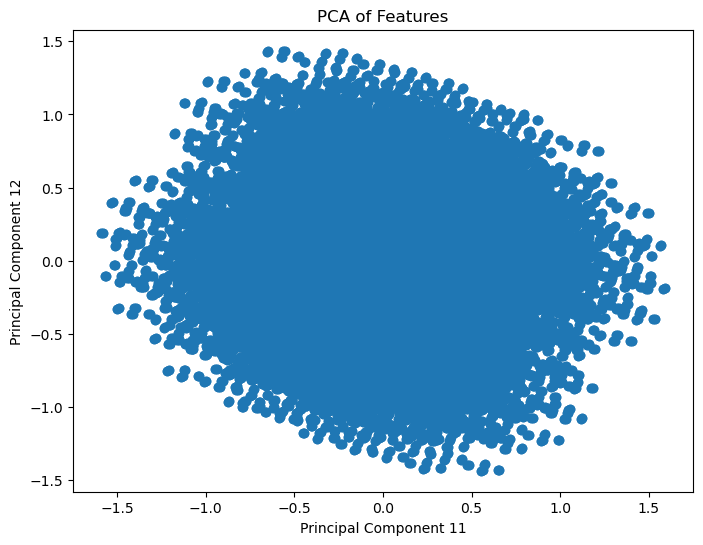

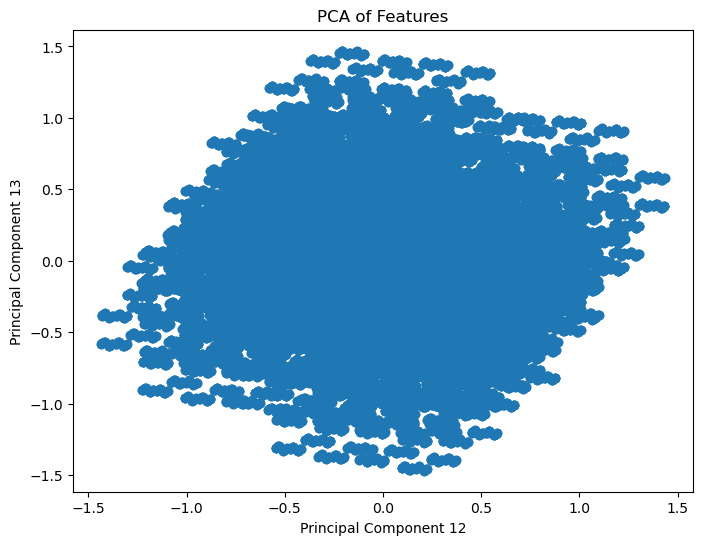

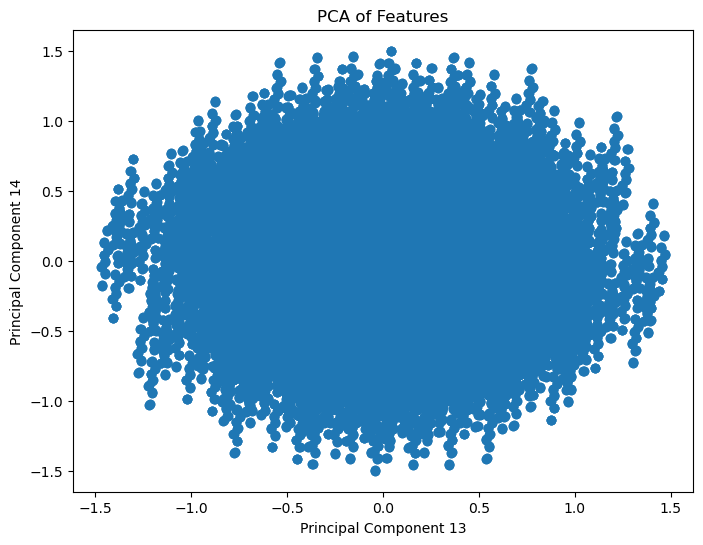

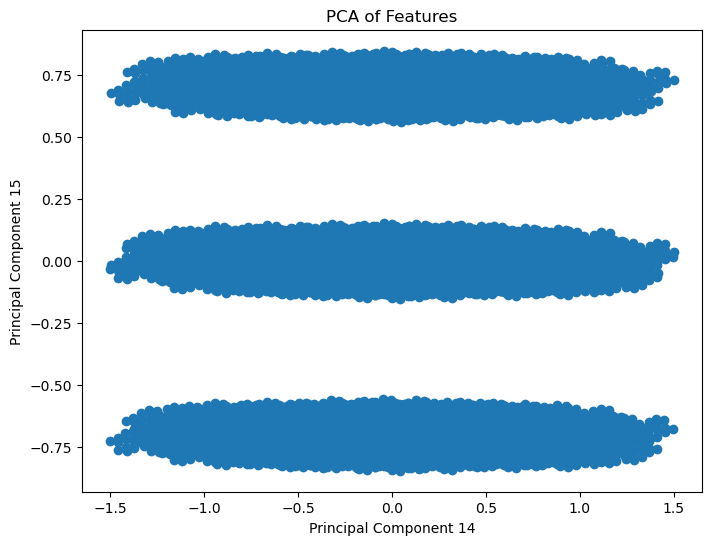

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=len(X_train.T))
#reduced_features = pca.fit_transform(X=X_train,y=y_train)
reduced_features = pca.fit_transform(measurement_df)

# Scatter plot of the first two principal components
for component in range(len(reduced_features.T)-1):
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_features[:, component], reduced_features[:, component+1])
        plt.xlabel(f'Principal Component {component}')
        plt.ylabel(f'Principal Component {component+1}')
        plt.title('PCA of Features')
        plt.show()


=> We can see clearly, that some interactions are linear separable, while most of them are not, beside having distinctive shapes indicating some interaction pattern

## pairwise interactions in KernelPCA

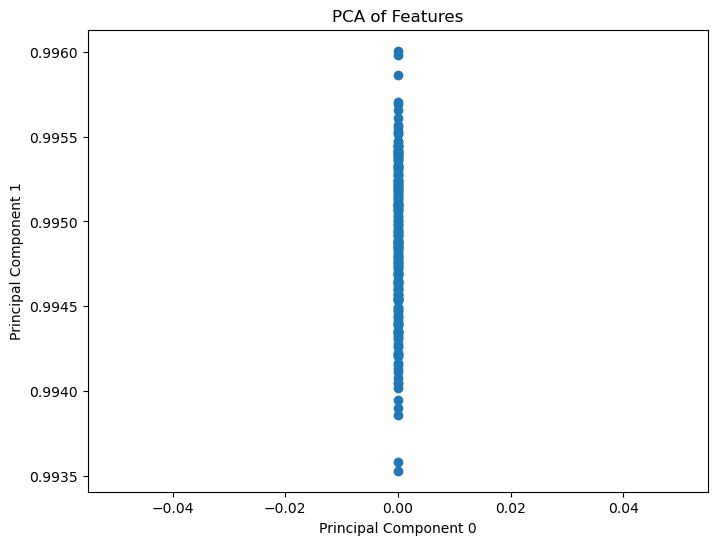

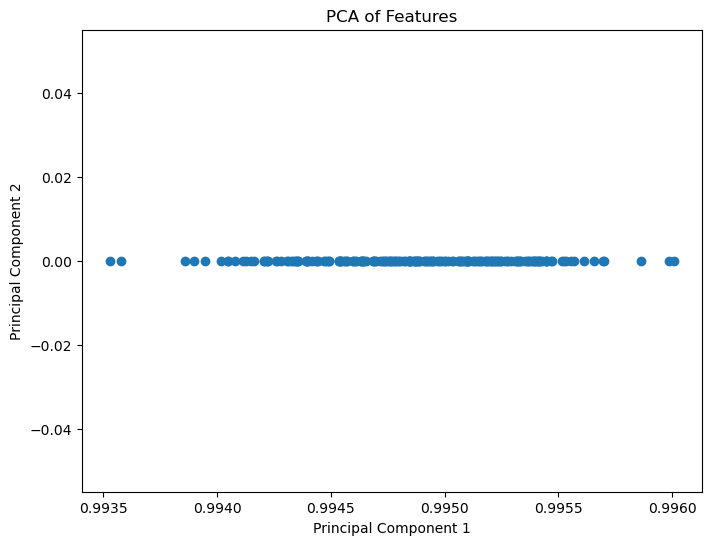

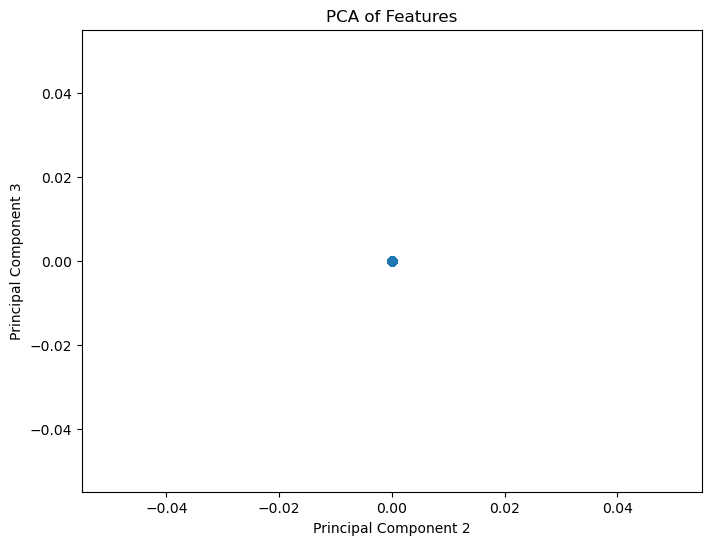

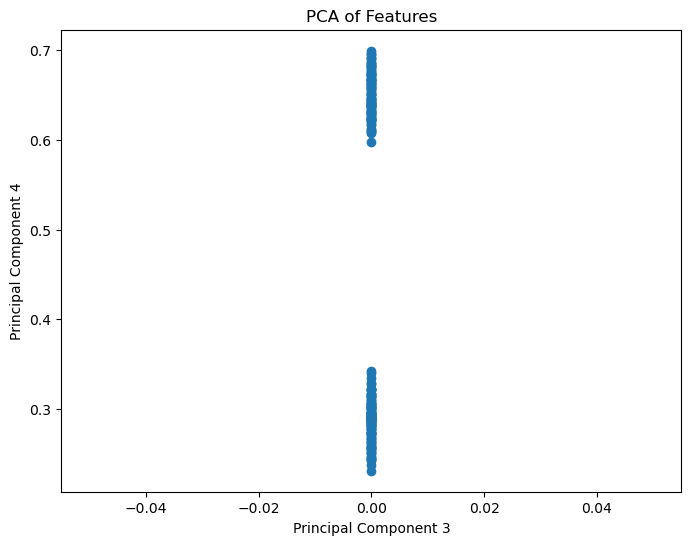

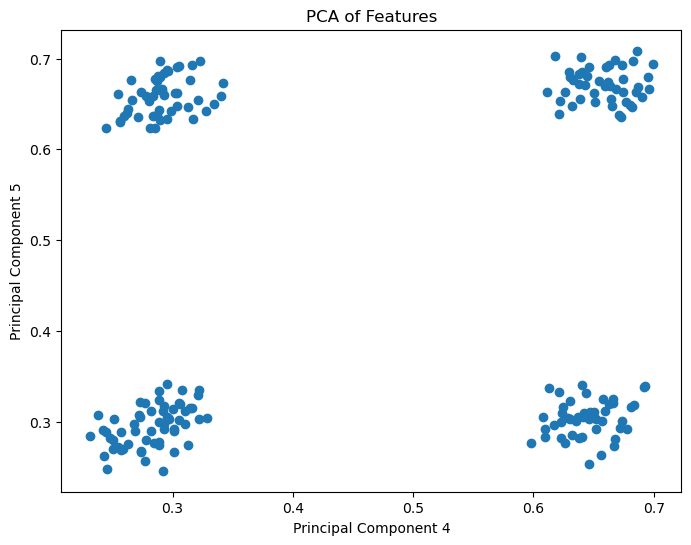

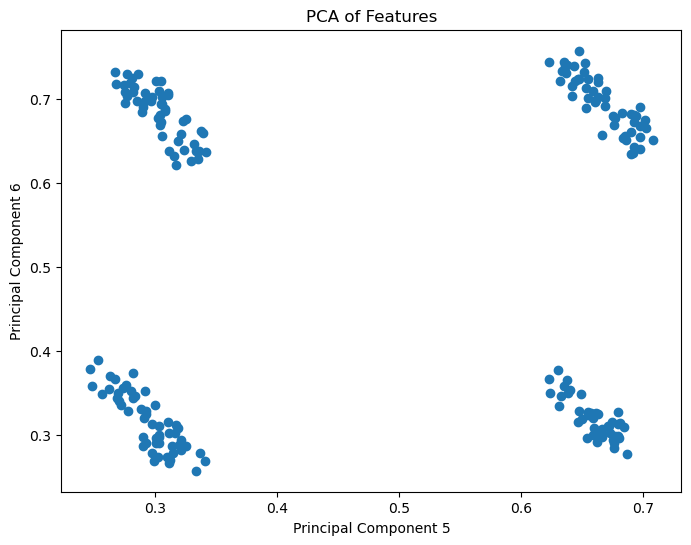

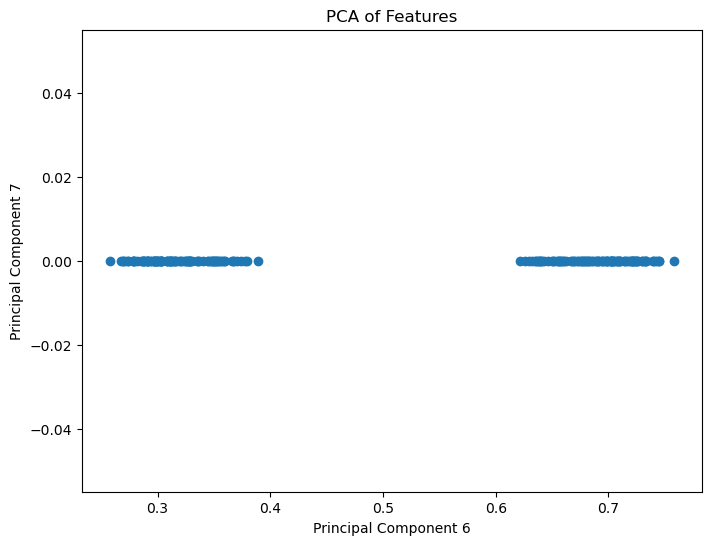

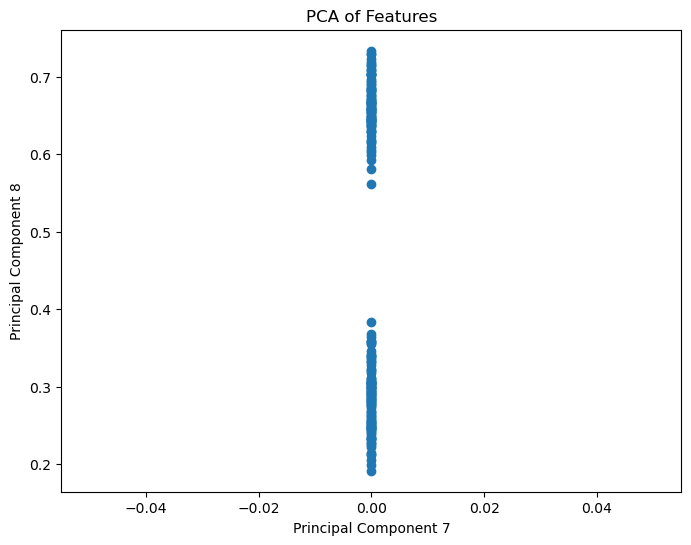

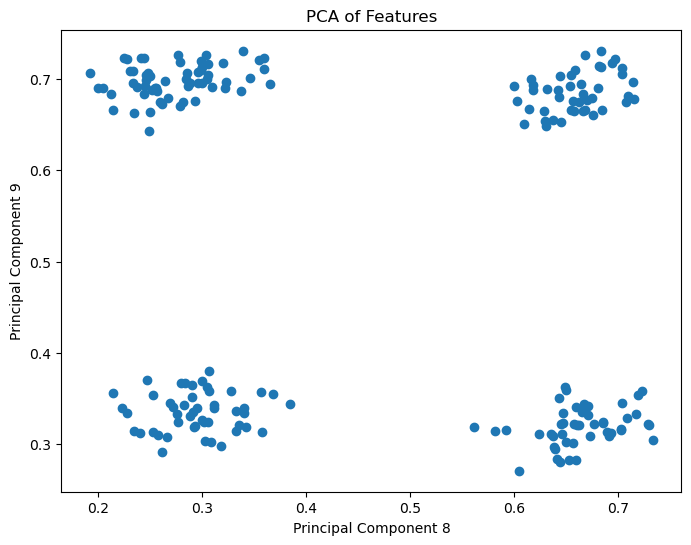

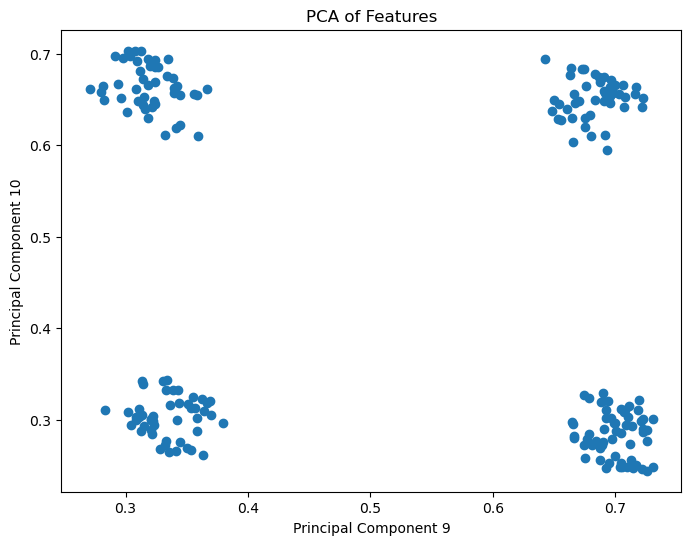

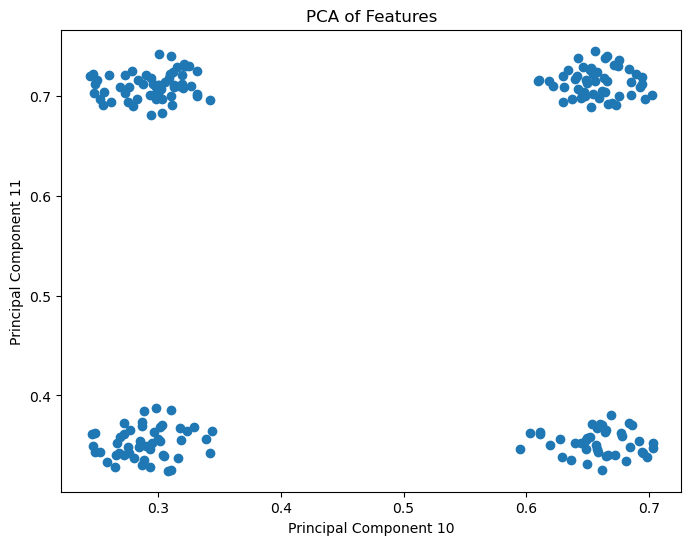

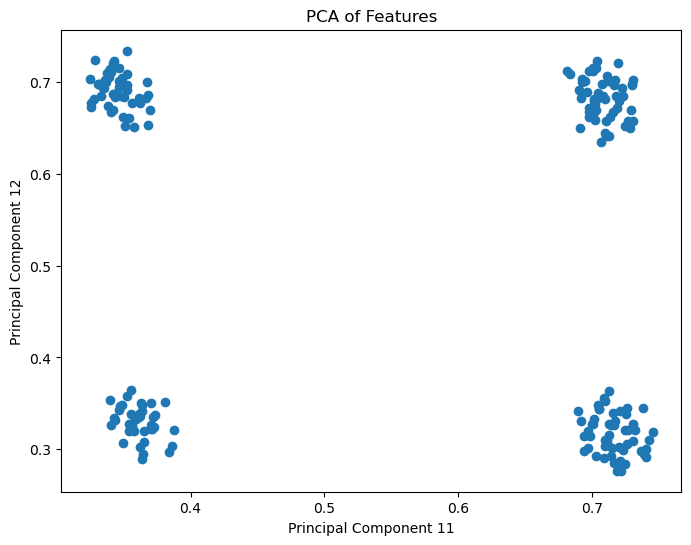

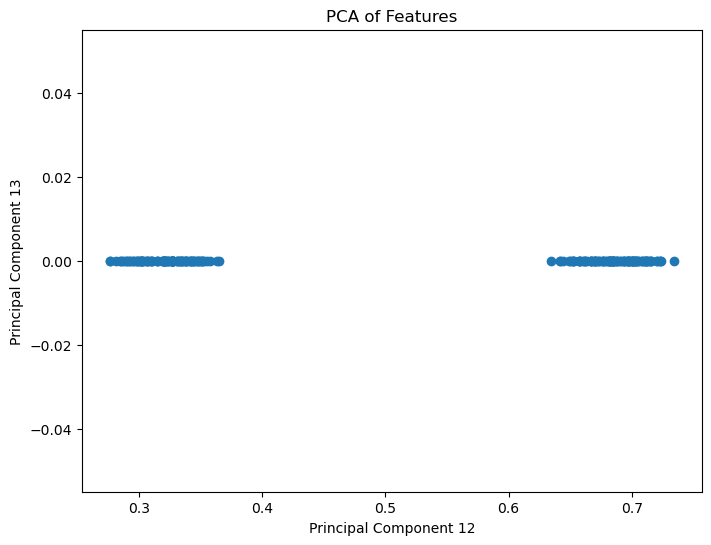

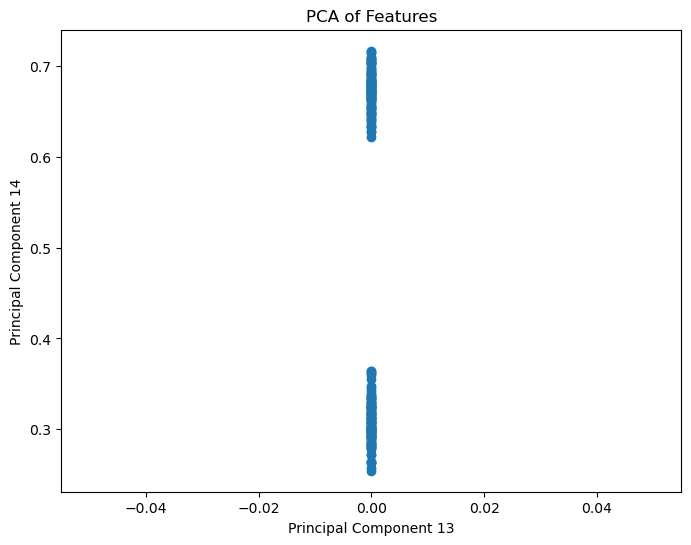

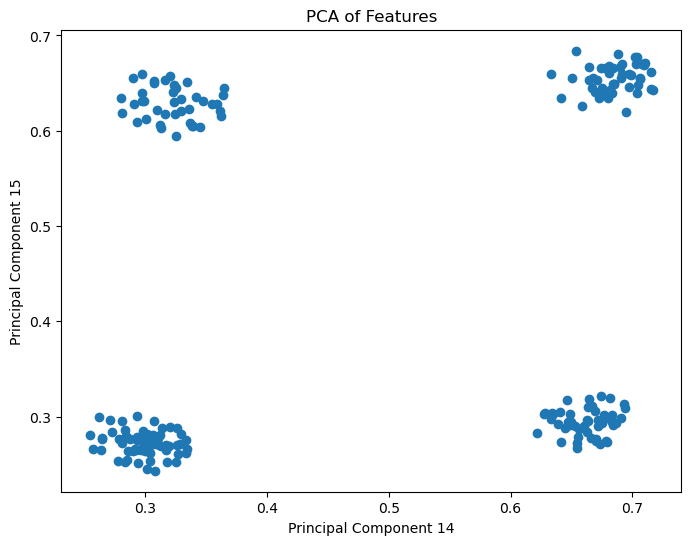

In [10]:
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

# Perform PCA
#pca = PCA(n_components=len(X_train.T))
pca = KernelPCA(kernel="rbf", n_components=len(X_train.T), fit_inverse_transform=True)
kpca = pca.fit_transform(X=X_train,y=y_train)
reduced_features = pca.inverse_transform(kpca)

# Scatter plot of the first two principal components
for component in range(len(reduced_features.T)-1):
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_features[:, component], reduced_features[:, component+1])
        plt.xlabel(f'Principal Component {component}')
        plt.ylabel(f'Principal Component {component+1}')
        plt.title('PCA of Features')
        plt.show()


- using a proper kernel, the data gets linear separated and variance reduced

##### This indicates, that a Gaussian Process Regression for multivariate normal distribution among the features is suitable

# Feature Engineering
## hierarchical constrains and views
- AVL tree inducing a ordered feature dict
## non-linear / latent feature selection
- we might want to constrain the training data to have specific feature combinations available
  - using boolean logic (CNFs/DNFs) to select feature combinations
- inspect data to detect a priori interaction patterns
    - we might want to intensify inspections on features that have a high correlation coefficient

## Polynomial Interaction Sampler
- using boolean algebra according to https://en.wikipedia.org/wiki/Zhegalkin_polynomial

### Decomposing feature strings
- imagine we have a binary encoded feature string / vector *p = 1011011* and want to know which features may interact with another
  vector *q = 1101101*, then we can just subtract q from p and look which feature combinations I have to add, to produce q:
  
  **p - q = 1000000 + 1000 + 1 - (10010 + 1110 + 10)**

- So when interested in interactions between p and q, we have to consider interactions between each substring and its opposite

### Boolean Feature Masks
- for **interactions** we concat samples with specific feature combinations **A** with a logical **AND**
- to get the **opposites not(A)**, we concat with **NAND**

def build_masks(X, conditions):
    masks = []
    for pos, opt in conditions:
        if len(X.T) < pos < 0:
            raise ValueError("pos must be a valid index of X.")
        if type(opt) != bool and opt not in [0,1]:
            raise ValueError("opt must be a \"boolean\".")
        masks.append(X[:,pos] == opt)
    return masks

def get_words(X, masks, clause="or"):
    if clause == "or":
        return X[np.logical_or(*masks)]
    elif clause == "nor":
        return X[np.logical_not(np.logical_or(*masks))]
    elif clause == "and":
        return X[np.logical_and(*masks)]
    elif clause == "nand":
        return X[np.logical_not(np.logical_and(*masks))]
    elif clause == "xor":
        return X[np.logical_xor(*masks)]


def get_interactions(X, features):
    masks = build_masks(X, features)
    print(masks)
    interactions = get_words(X, masks, clause="and")
    return interactions

def get_opposites(X, features):
    masks = build_masks(X, features)
    print(masks)
    opposites = get_words(X, masks, clause="nand")
    return opposites

feature_interactions = [(1,0),(2,1),(3,1)]
A = get_interactions(np.array(X_train), feature_interactions)
not_A = get_opposites(np.array(X_test), feature_interactions)

print(f"A: {A}\n")
print(f"not A: {not_A}")


print("sanity check, if A and not_A are distinct")
if np.size(np.setdiff1d(A,not_A)) == 0:
    print(True)
else:
    print(False)

## pairwise and groupwise affinities and distance measures
- https://scikit-learn.org/stable/modules/metrics.html#metrics
- KLD, Jenson-Shannon ~ RATE


- groupwise:
-> Just build X_test with desired combinations of interactions using the boolean masks
-> for out of sample prediction take the opposites_and_interactions mode

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import chi2_kernel, laplacian_kernel, polynomial_kernel



## Graphical Lasso
- to find dependency structure which reduces resampling complexity

## GMM

0
2
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
1
4
Initialization 0
  Iteration 10
Initialization converged: True
2
8
Initialization 0
Initialization converged: True
3
12
Initialization 0
Initialization converged: True
4
16
Initialization 0
Initialization converged: True


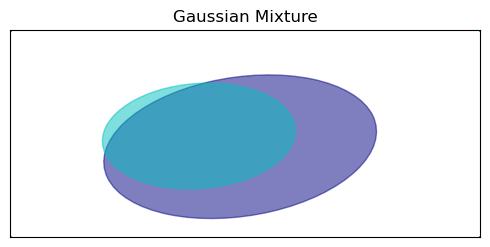

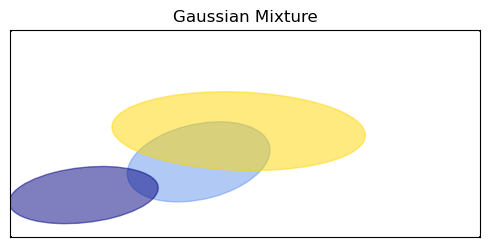

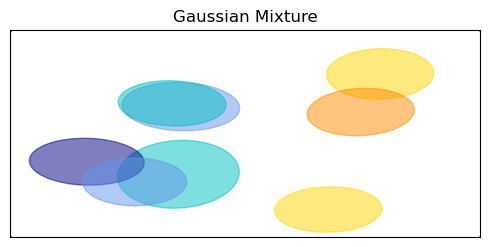

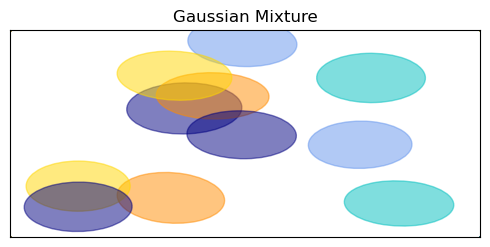

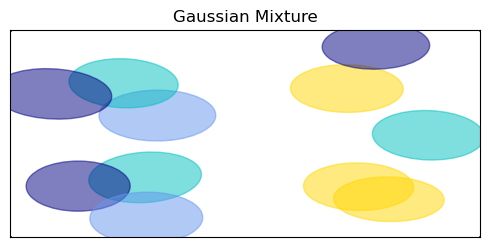

In [24]:
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
np.seterr('raise')

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results_(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color, feature_name) in enumerate(zip(means, covariances, color_iter, feature_names)):
        v, w = np.linalg.eigh(covar)
        v = 2 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        #plt.text(mean[0], mean[1], feature_name, ha='center', va='center', color='black')

#    plt.xlim(-9.0, 5.0)
#    plt.ylim(-3.0, 6.0)
    plt.xlim(np.min(X[:, 0]), np.max(X[:, 0]))
    plt.ylim(np.min(X[:, 1]), np.max(X[:, 1]))
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], 0.8, color=color)

    plt.xlim(-6.0, 4.0 * np.pi - 6.0)
    plt.ylim(-5.0, 5.0)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())

#gmm = GaussianMixture(n_components=4, covariance_type="tied", tol=1e-4)
TRIALS = 5
components = [2,4,8,12,16]
gmms = {}
for i, components in enumerate(components):
    print(i)
    print(components)
    gmms[i] = BayesianGaussianMixture(weight_concentration_prior_type="dirichlet_distribution",n_components=components, covariance_type="full", verbose=1, max_iter=100000, random_state=42)
    gmms[i].fit(X_train, y_train)
    plt.figure(figsize=(5, 5))
    plt.subplots_adjust(
        bottom=0.04, top=0.95, hspace=0.2, wspace=0.05, left=0.03, right=0.97
    )
    plot_results_(X_train, gmms[i].predict(X_test), gmms[i].means_, gmms[i].covariances_, 0, "Gaussian Mixture")

There is no clear center! 

In [22]:
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

X_train.shape: (100, 16)
y_train.shape: (100,)


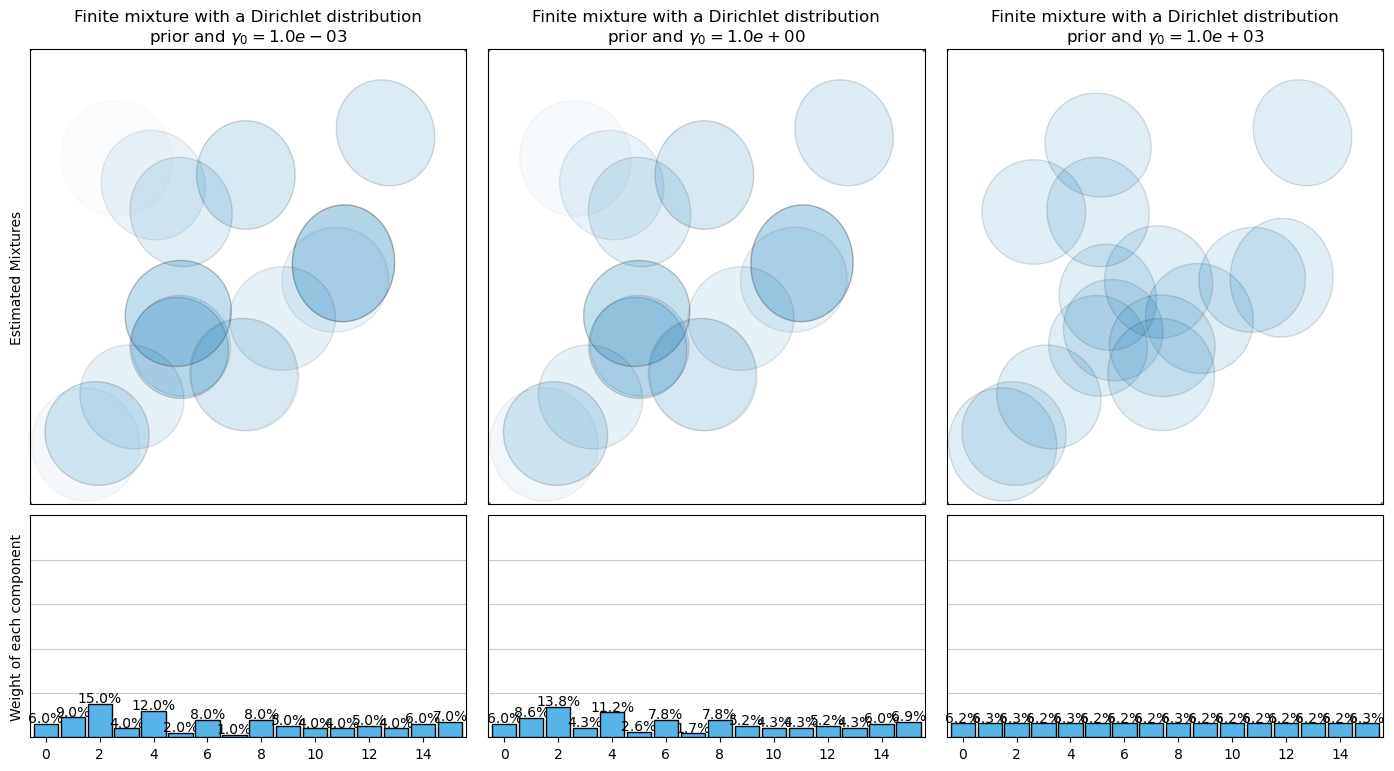

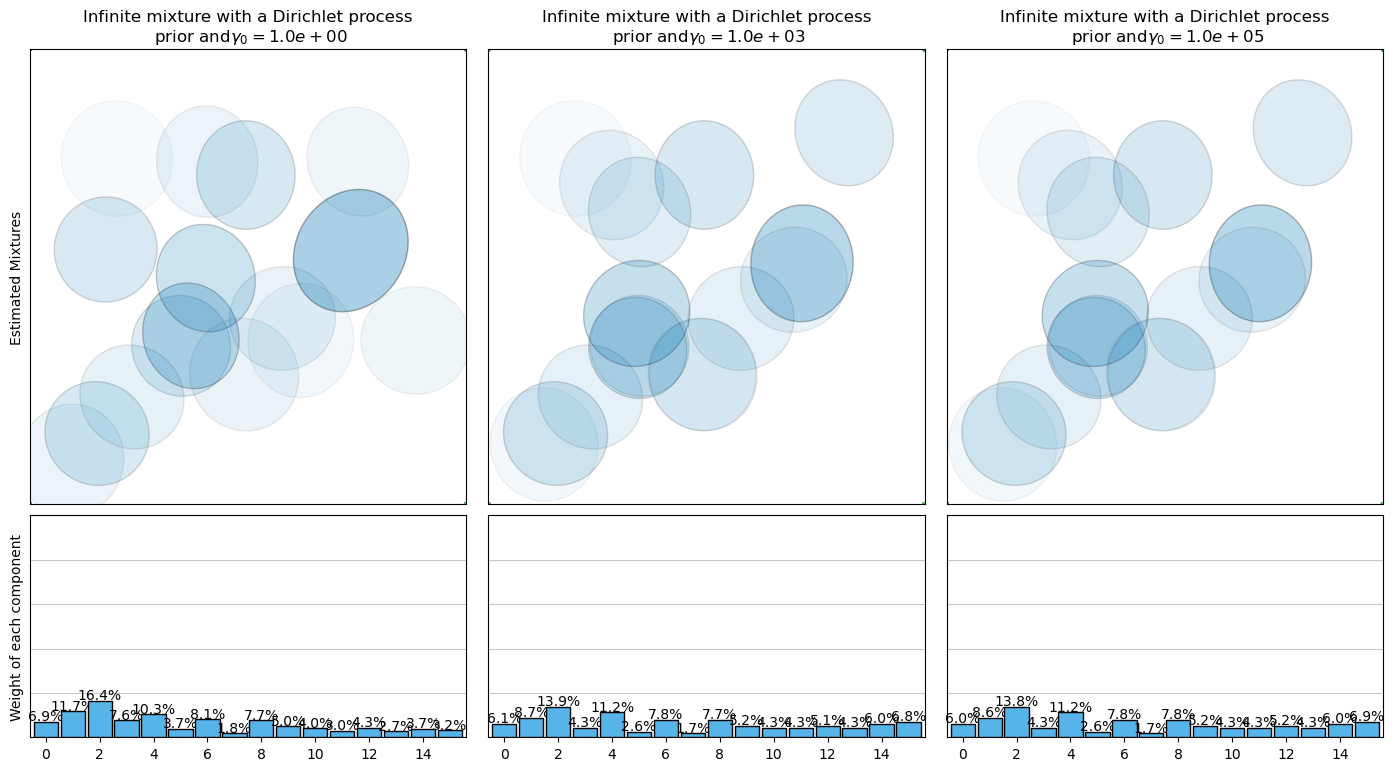

In [20]:
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from sklearn.mixture import BayesianGaussianMixture

def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(
            means[n], eig_vals[0], eig_vals[1], angle=180 + angle, edgecolor="black"
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(2*weights[n])
        ell.set_facecolor("#0072B2")
        ax.add_artist(ell)


def plot_results(ax1, ax2, estimator, X, y, title, plot_title=False):
    ax1.set_title(title)
    #ax1.scatter(X[:, 0], X[:, 1], s=5, marker="o", color="#D55E00", alpha=0.8)
    #ax1.scatter(X[:, 0], X[:, 1], s=5, marker="o", c=y, cmap='viridis', alpha=0.8)
    ax1.scatter(X[:, 0], X[:, 15], s=5, marker="o", c=y_train, cmap='viridis', alpha=0.8)
    ax1.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
    ax1.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
    ax1.set_xticks(())
    ax1.set_yticks(())
    plot_ellipses(ax1, estimator.weights_, estimator.means_, estimator.covariances_)

    ax2.get_xaxis().set_tick_params(direction="out")
    ax2.yaxis.grid(True, alpha=0.7)
    for k, w in enumerate(estimator.weights_):
        ax2.bar(
            k,
            w,
            width=0.9,
            color="#56B4E9",
            zorder=3,
            align="center",
            edgecolor="black",
        )
        ax2.text(k, w + 0.007, "%.1f%%" % (w * 100.0), horizontalalignment="center")
    ax2.set_xlim(-0.6, 2 * n_components - 0.4)
    ax2.set_ylim(0,1)
    ax2.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
    ax2.tick_params(axis="x", which="both", top=False)

    if plot_title:
        ax1.set_ylabel("Estimated Mixtures")
        ax2.set_ylabel("Weight of each component")


# Parameters of the dataset
random_state, n_components, n_features = 2, 8, 16
colors = np.array(["#0072B2", "#F0E442", "#D55E00", "#F0000", "#56B4E9", "#56B4E9"])

covars = np.array(
    [[[0.7, 0.0], [0.0, 0.1]], [[0.5, 0.0], [0.0, 0.1]], [[0.5, 0.0], [0.0, 0.1]]]
)
samples = np.array([200, 500, 200])
means = np.array([[0.0, -0.70], [0.0, 0.0], [0.0, 0.70]])

# mean_precision_prior= 0.8 to minimize the influence of the prior
estimators = [
    (
        "Finite mixture with a Dirichlet distribution\nprior and " r"$\gamma_0=$",
        BayesianGaussianMixture(
            weight_concentration_prior_type="dirichlet_distribution",
            n_components=2 * n_components,
            reg_covar=0,
            init_params="random",
            max_iter=1500,
            mean_precision_prior=0.8,
            random_state=random_state,
        ),
        [0.001, 1, 1000],
    ),
    (
        "Infinite mixture with a Dirichlet process\n prior and" r"$\gamma_0=$",
        BayesianGaussianMixture(
            weight_concentration_prior_type="dirichlet_process",
            n_components=2 * n_components,
            reg_covar=0,
            init_params="random",
            max_iter=1500,
            mean_precision_prior=0.8,
            random_state=random_state,
        ),
        [1, 1000, 100000],
    ),
]

y_train = np.array(y_train, dtype=int)
# Plot results in two different figures
for title, estimator, concentrations_prior in estimators:
    plt.figure(figsize=(4.7 * 3, 8))
    plt.subplots_adjust(
        bottom=0.04, top=0.90, hspace=0.05, wspace=0.05, left=0.03, right=0.99
    )

    gs = gridspec.GridSpec(3, len(concentrations_prior))
    for k, concentration in enumerate(concentrations_prior):
        estimator.weight_concentration_prior = concentration
        estimator.fit(X_train)
        plot_results(
            plt.subplot(gs[0:2, k]),
            plt.subplot(gs[2, k]),
            estimator,
            X_train,
            y_train,
            r"%s$%.1e$" % (title, concentration),
            plot_title=k == 0,
        )

plt.show()

As we see, the weight concentration prior is necessary to find a convex subspace where the GMM can converge to
This is reflected by the divergence of the GP model with constant mean.
By utilizing the empirical bayes method we can precalculate a weighted mean from the data and don't need to 
rescale otherwise. 

In [39]:
import torch
from domain.env import MODELDIR
from adapters.gpytorch.gp_model import SAASGP

file_name = "SAASGP_linear_weighted_matern52_simple_ARD=False__20240208-211611"
model_file = f"{MODELDIR}/{file_name}.pth"

model = SAASGP(X_train, y_train, feature_names)
model.load_state_dict(torch.load(model_file), strict=False)


Getting priors from lin regs.
fitting 50 regressors
RidgeCV
analogue LR train set set r2 score: 0.9844602953176073
analogue LR train set set mape score: 1.2149593601086235
analogue LR train set set rmse score: 39.45891280693917

LassoCV
analogue LR train set set r2 score: 0.9844423642543964
analogue LR train set set mape score: 1.215877628233854
analogue LR train set set rmse score: 39.48167180675688

Prior Spectrum Computation took 1.9554111957550049


/home/immanuel/.conda/envs/bayesrisk/lib/python3.9/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


In [41]:
model.eval()
with torch.no_grad():
    posterior = model.posterior(X_test)
    confidence_region = posterior.mvn.confidence_region()

    # create dimensional model
    dims = len(model.X.T)
    dimensional_model = {}
    for dim in range(dims):
        dimensional_model[dim] = {}
        dimensional_model[dim]["X"] = X_train[:, dim]
        dimensional_model[dim]["feature_name"] = feature_names[dim]
        dimensional_model[dim]["y"] = y_train
        dimensional_model[dim]["X_test"] = X_test[:, dim]
        dimensional_model[dim]["mean"] = posterior.mean[dim]
        dimensional_model[dim]["variance"] = posterior.variance[dim]
        dimensional_model[dim]["std"] = torch.sqrt(posterior.variance[dim])
        dimensional_model[dim]["covariance"] = posterior.covariance_matrix[dim]
        dimensional_model[dim]["lower"] = confidence_region[0][dim]
        dimensional_model[dim]["upper"] = confidence_region[1][dim]


In [49]:
from adapters.gpytorch.util import decompose_matrix, get_beta, get_thetas
from domain.feature_model.feature_modeling import inverse_map

CONFIDENCE = 0.95

U, lam, V = decompose_matrix(dimensional_model[0]["covariance"]) # example for first dimension
explained_var = np.cumsum(np.array(lam) / np.sum(np.array(lam)))
p = len(model.X.T)
# estimate, how much of the explained variance is explained by p components
p_explained_var = explained_var[p - 1]
print(f"{p_explained_var}.2f of the variance is explained by {p} components (the base features)")
q = np.where(explained_var >= CONFIDENCE)[0][0] + 1 # number of principal components to explain confidential proportion of variance
qq = next(x[0] for x in enumerate(explained_var) if x[1] > CONFIDENCE) + 1
qqq = next(i + 1 for i, var in enumerate(explained_var) if var >= CONFIDENCE)
Lambda = np.diag(np.sort(lam)[::-1])[:q] # diagonal matrix with first q eigenvalues 
U = U[:, :q] # first q columns
B = inverse_map(model.X.T, U)
Laplace_approximation = B @ B.T
thetas = get_thetas(dimensional_model[0]["covariance"], q)
betas = get_beta(B, thetas)

X is not full rank. Rank(X) = 17
0.9999976820685903.2f of the variance is explained by 16 components (the base features)
X is not full rank. Rank(X) = 17
i = 0
B.shape = torch.Size([16, 7])
thetamat.shape = torch.Size([100, 7])
betamat[:, i] = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
betamat[:, i].shape = (16,)
thetamat[i, :] = tensor([-47250476.1120, -11538949.2134, -38771941.1836, -31178558.4150,
        -51603163.7052, -21960896.7755, -58168453.7735], dtype=torch.float64)
thetamat[i, :].shape = torch.Size([7])


/home/immanuel/Dokumente/Master Thesis/dev/energy-influence-model-structure-uncertainty/adapters/gpytorch/util.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
/home/immanuel/Dokumente/Master Thesis/dev/energy-influence-model-structure-uncertainty/domain/feature_model/feature_modeling.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
/home/immanuel/Dokumente/Master Thesis/dev/energy-influence-model-structure-uncertainty/domain/feature_model/feature_modeling.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

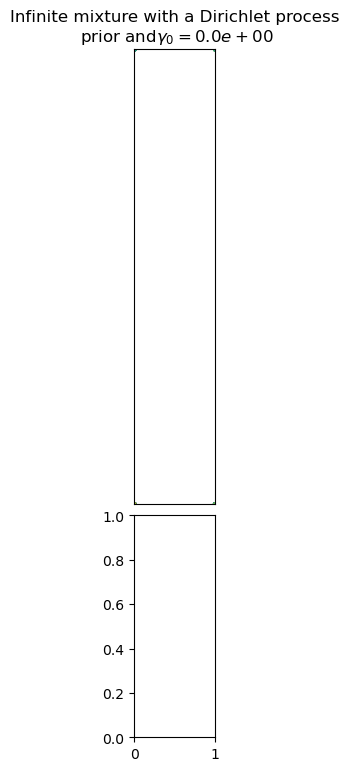

In [56]:
plt.figure(figsize=(4.7 * 3, 8))
plt.subplots_adjust(
    bottom=0.04, top=0.90, hspace=0.05, wspace=0.05, left=0.03, right=0.99
)
 #estimator.weights_, estimator.means_, estimator.covariances_ => 
estimator.mean_ = dimensional_model[1]["mean"]
estimator.covariances_ = dimensional_model[1]["covariance"]
#estimator.weights_ = 
gs = gridspec.GridSpec(3, len(dimensional_model.keys()))
for k, concentration in enumerate(dimensional_model.keys()):
    plot_results(
        plt.subplot(gs[0:2, k]),
        plt.subplot(gs[2, k]),
        estimator,
        X_train,
        y_train,
        r"%s$%.1e$" % (title, concentration),
        plot_title=k == 0,
    )
    break

plt.show()